# 프로젝트 2 : 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt

In [3]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error # for regression


## (1) 데이터 가져오기

In [4]:
## Local로 작업

In [5]:
train_df = pd.read_csv('./data/bike_train.csv')
test_df = pd.read_csv('./data/bike_test.csv')
df = train_df.copy()

In [6]:
display(df.shape)
display(df.describe())
df.head()

(10886, 12)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Data Fields**. 
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
-           2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
-           3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
-           4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### Null Value Check

In [8]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<Axes: >

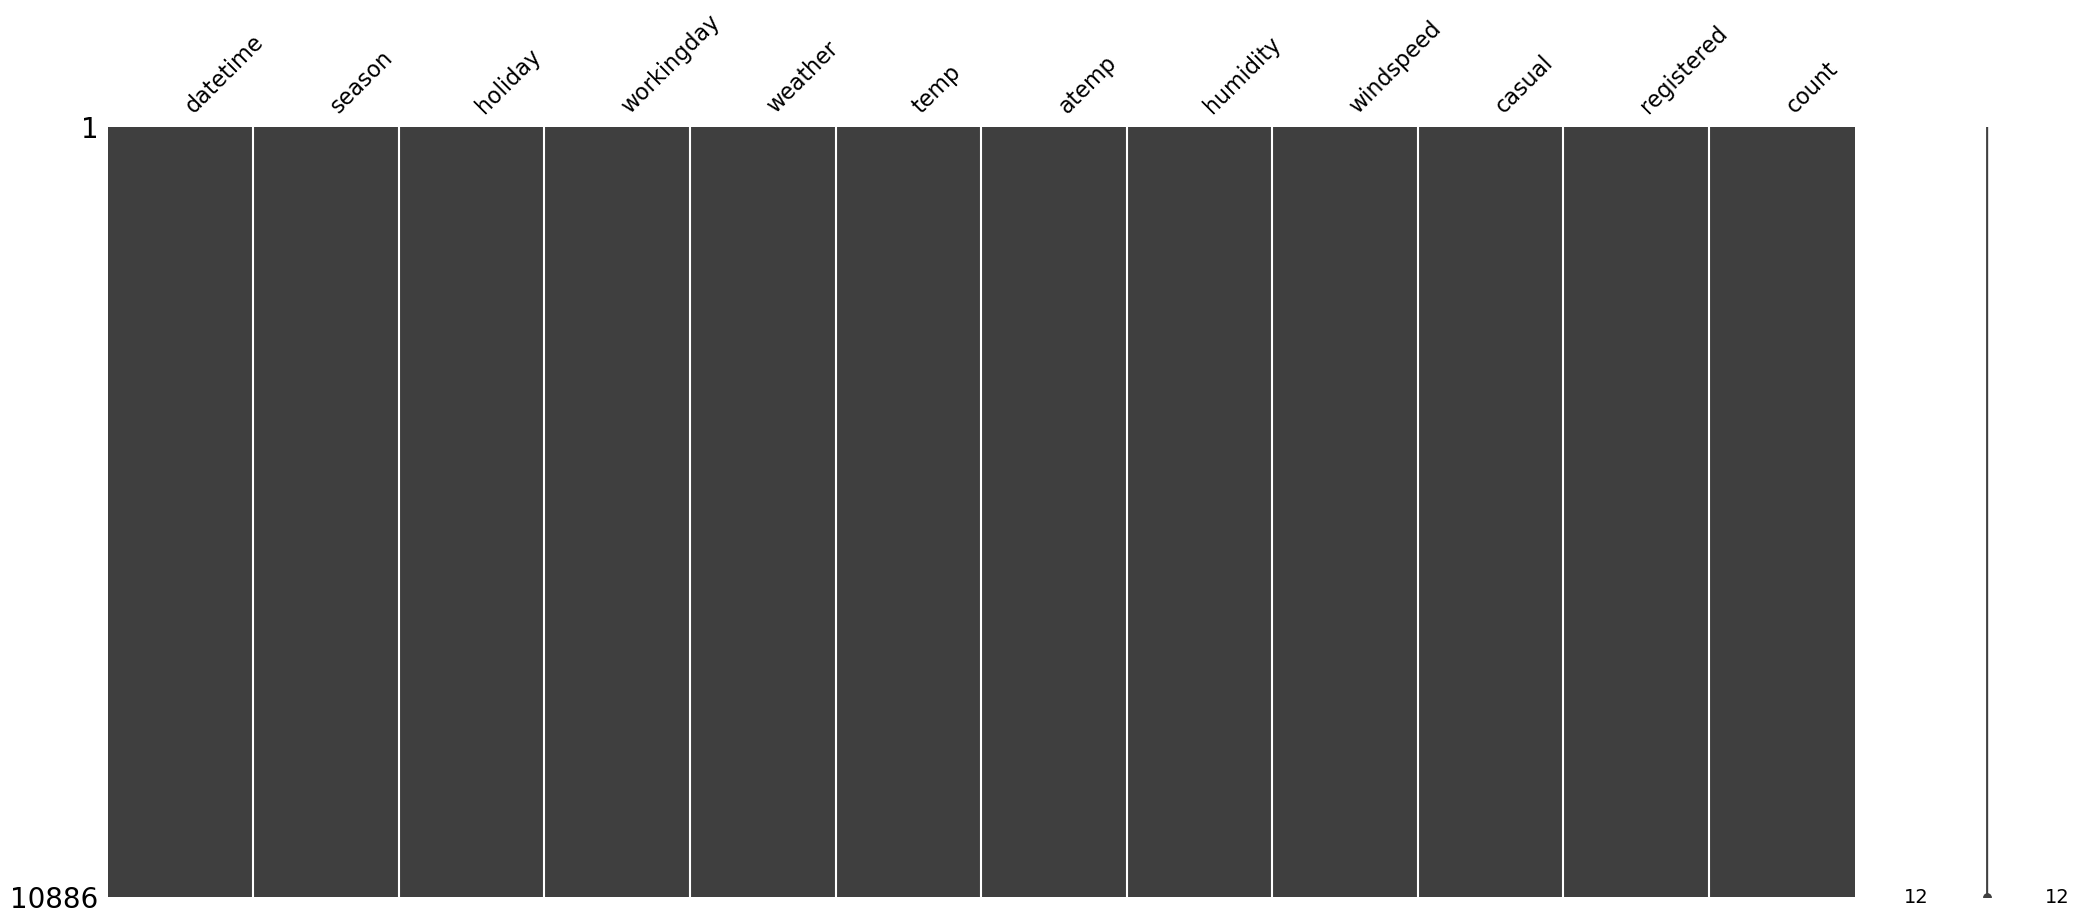

In [9]:
msno.matrix(df)

## (2) datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [11]:
#weekday 도 중요 피쳐라 추가로 축출
datetime_col = ['year','month','day','weekday','hour','minute','second']

for col in datetime_col:
    df[col] = getattr(df['datetime'].dt, col)

## (3) year, month, day, hour, minute, second 데이터 개수 시각화하기

### Count_Plot

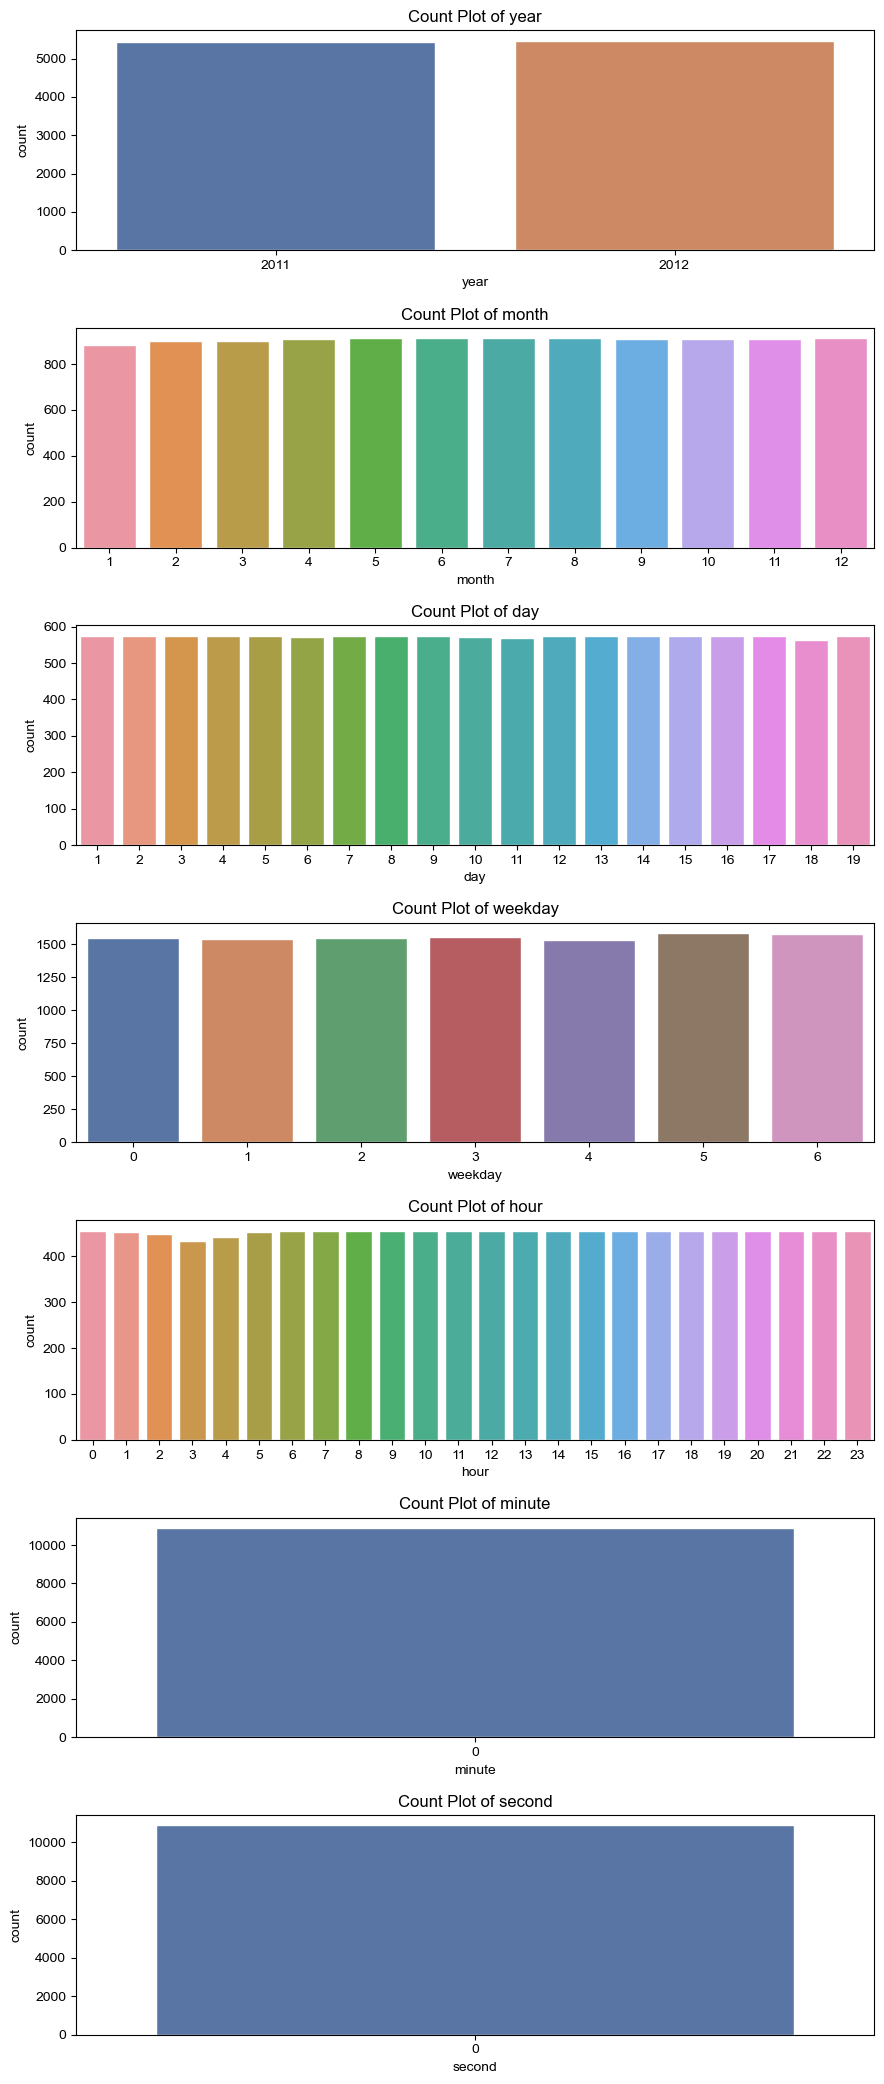

In [12]:
nrows, ncols = len(datetime_col), 1
fig, axs = plt.subplots(nrows,ncols,figsize=(9,3*nrows))
for i in range(len(datetime_col)):
    sns.set_theme(style="whitegrid")
    sns.countplot(x=df[datetime_col[i]],data=df, ax=axs[i])
    axs[i].set_title('Count Plot of {}'.format(datetime_col[i]))
plt.tight_layout()
plt.show()

### Bar_Plot

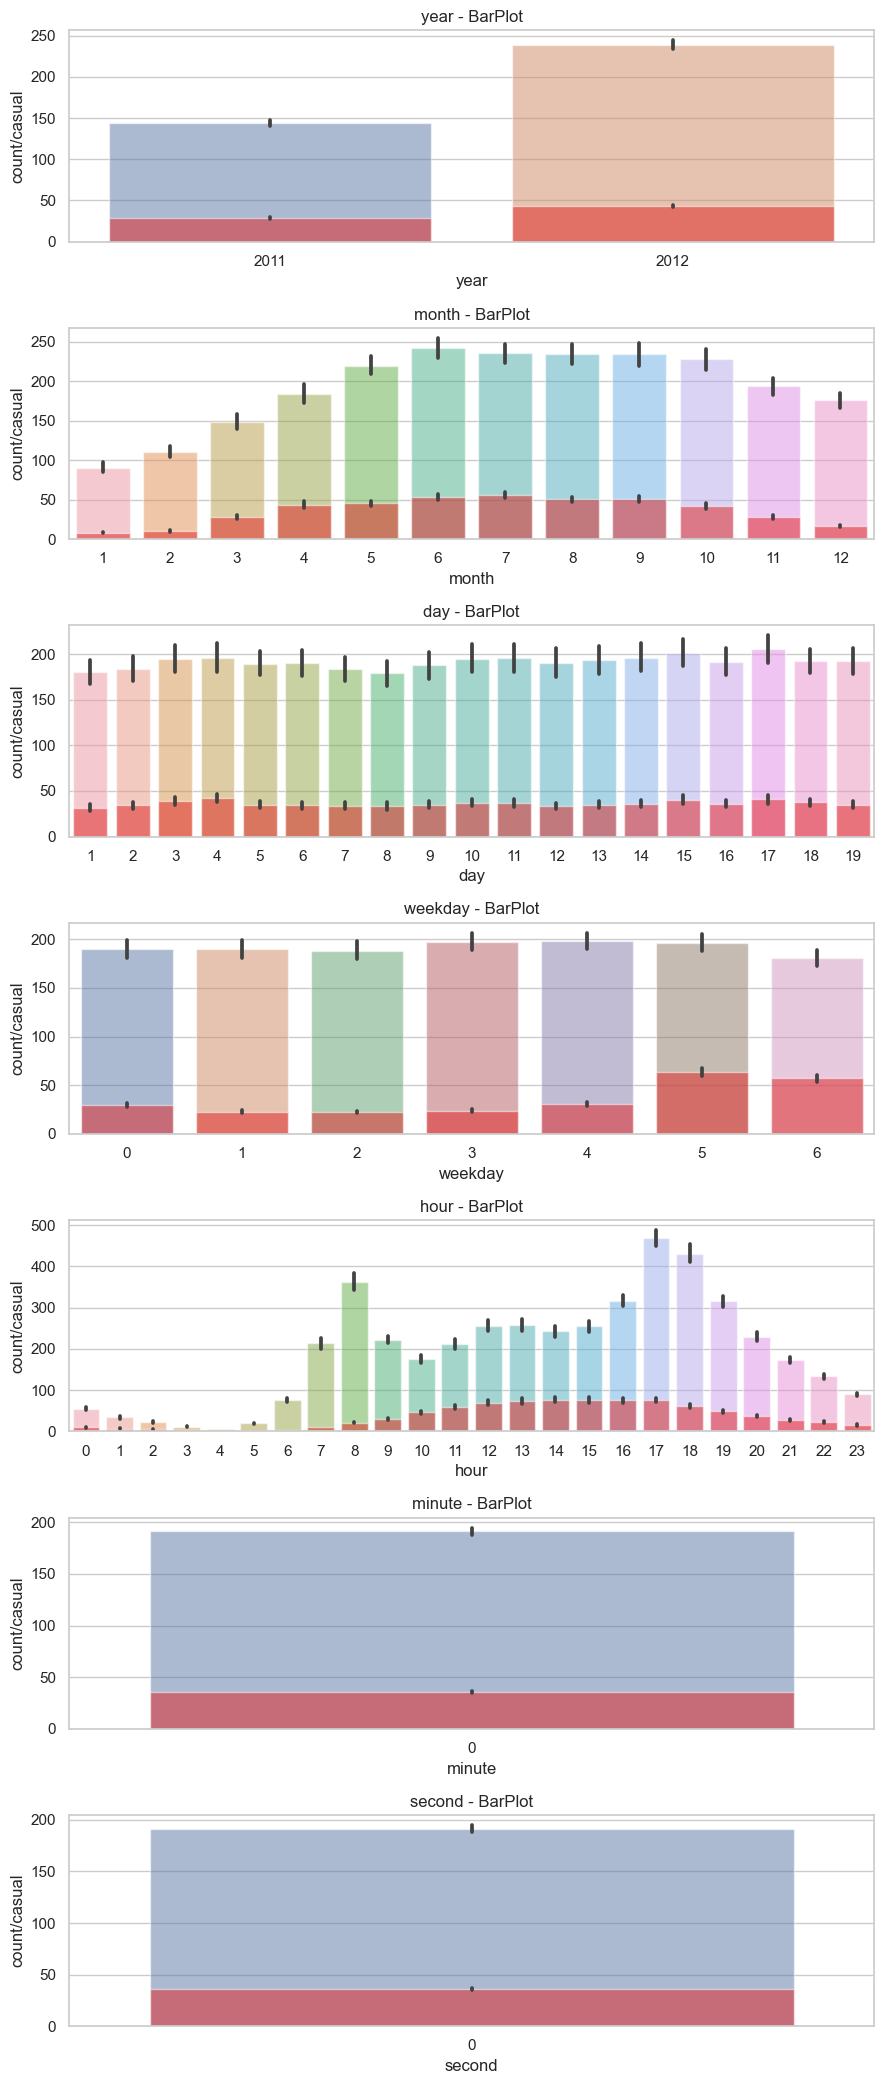

In [13]:
#counter plot 으로는 데이터 구분이 힘들어 bar_plot 으로 다시 그림, counter 와 다른 양상을 지닌, casual 도 같이 그림
fig, axs = plt.subplots(nrows,ncols,figsize=(9,3*nrows))
for i in range(len(datetime_col)):
    sns.barplot(data=df,x=datetime_col[i],y='count',ax=axs[i],alpha=0.5)
    sns.barplot(data=df,x=datetime_col[i],y='casual',ax=axs[i],alpha=0.5,color='red')
    axs[i].set_title('{} - BarPlot'.format(datetime_col[i]))
    axs[i].set_ylabel('count/casual')
plt.tight_layout()
plt.show()

## (4) X, y 컬럼 선택 및 train/test 데이터 분리

### Data Backfill - 결측치 채우기 

In [14]:
df['windspeed'].value_counts()

windspeed
0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: count, dtype: int64

In [15]:
df['windspeed'] = df['windspeed'].replace(0,np.nan)
df['windspeed'].isnull().sum()

1313

In [16]:
df['windspeed'].fillna(method='bfill',inplace=True)
df['windspeed'].isnull().sum()
df['windspeed'].value_counts()

windspeed
7.0015     1374
8.9981     1332
6.0032     1310
11.0014    1176
12.9980    1127
15.0013     987
16.9979     872
19.0012     694
19.9995     507
22.0028     380
23.9994     276
26.0027     236
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      59
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: count, dtype: int64

### Outlier : IQR - Count 만 적용

<Axes: ylabel='count'>

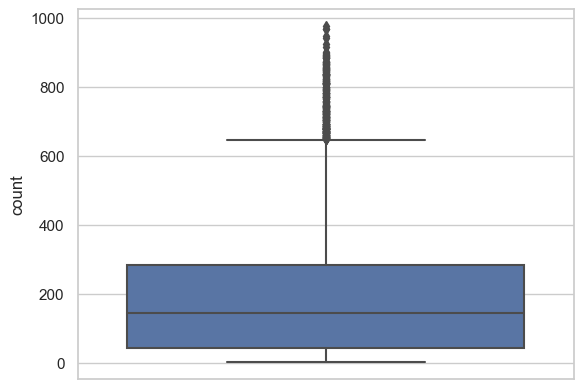

In [17]:
sns.boxplot(data=df,y='count')

<Axes: xlabel='hour', ylabel='count'>

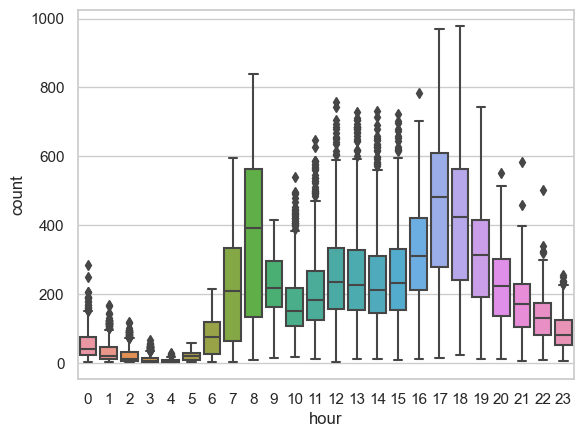

In [18]:
sns.boxplot(data=df,y='count',x='hour')

In [19]:
Q1 = df['count'].quantile(0.25)
Q3 = df['count'].quantile(0.75)

print(Q1,Q3)

IQR = Q3-Q1

42.0 284.0


In [20]:
filter = (df['count'] >= Q1 - 1.5 * IQR) & (df['count'] < Q3 + 1.5 *IQR )

display(df.loc[filter].shape)
display(df.shape)

df_clean = df.loc[filter]

(10583, 19)

(10886, 19)

In [21]:
df = df_clean.copy()

### Correlation 

<Axes: >

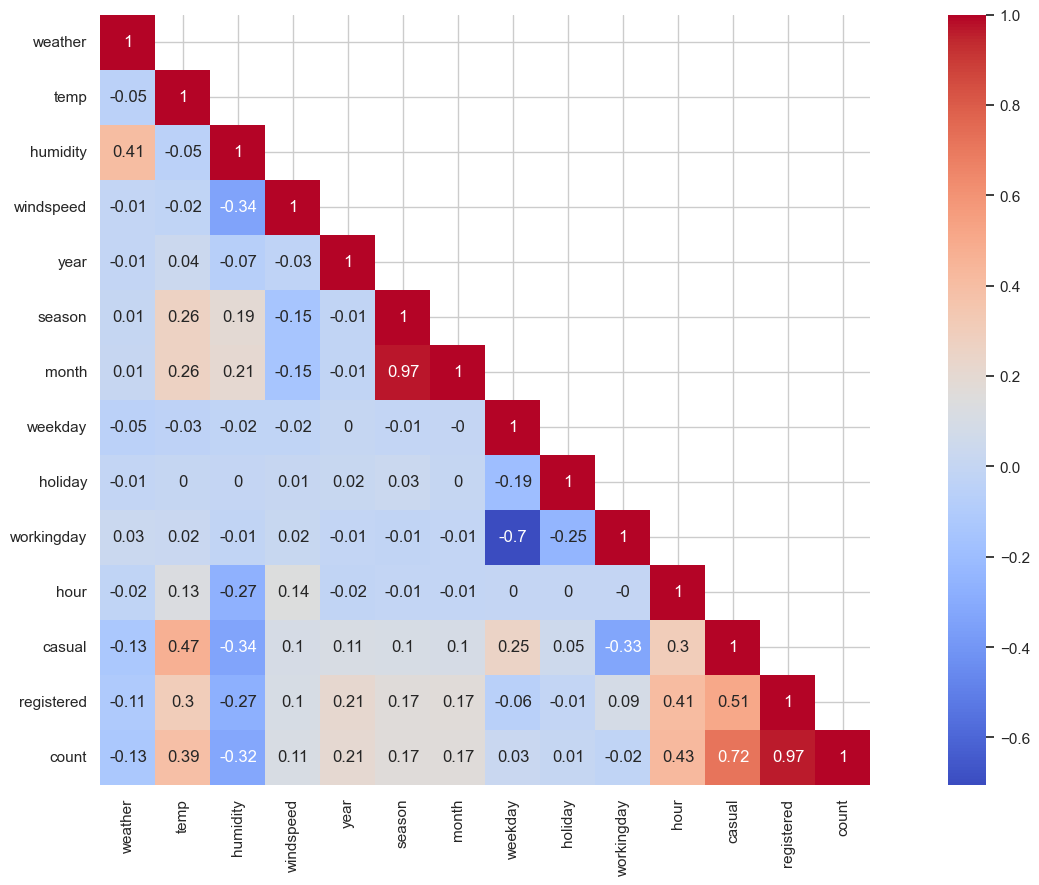

In [22]:
clean_col = [ 'weather', 'temp', 'humidity', 'windspeed', 
              'year','season', 'month', 'weekday', 'holiday', 'workingday', 'hour',
              'casual', 'registered', 'count']

correlation = df[clean_col].corr()

fig, ax = plt.subplots(figsize=(20,10))
mask = np.array(correlation)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(correlation,square=True,annot=np.round(correlation,2),mask=mask,cmap='coolwarm')

In [23]:
correlation.index.name = 'category'
correlation.T.index.name = 'relevant_category'

corr_df = pd.DataFrame(correlation.stack(),columns=['correaltion']).reset_index()
corr_df = corr_df.loc[corr_df['category'] != corr_df['relevant_category']]
corr_df['rank'] = corr_df.groupby('category')['correaltion'].rank('min',ascending=False).astype(int)
corr_df.sort_values('correaltion',ascending=False)

,category,relevant_category,correaltion,rank
76,season,month,0.971936,1
89,month,season,0.971936,1
181,registered,count,0.966296,1
194,count,registered,0.966296,1
193,count,casual,0.716661,2
...,...,...,...,...
156,casual,humidity,-0.335204,13
31,humidity,windspeed,-0.341241,13
44,windspeed,humidity,-0.341241,13
133,workingday,weekday,-0.704199,13


#### [count - features] correlation rank

In [24]:
corr_df[corr_df['category']=='count'].sort_values('rank')

,category,relevant_category,correaltion,rank
194,count,registered,0.966296,1
193,count,casual,0.716661,2
192,count,hour,0.426164,3
183,count,temp,0.387816,4
186,count,year,0.205818,5
188,count,month,0.167439,6
187,count,season,0.165037,7
185,count,windspeed,0.113736,8
189,count,weekday,0.025890,9
190,count,holiday,0.007779,10


#### [casual - features] correlation rank

In [25]:
corr_df[corr_df['category']=='casual'].sort_values('rank')

,category,relevant_category,correaltion,rank
167,casual,count,0.716661,1
166,casual,registered,0.512966,2
155,casual,temp,0.468881,3
164,casual,hour,0.302234,4
161,casual,weekday,0.251154,5
158,casual,year,0.113232,6
159,casual,season,0.102565,7
157,casual,windspeed,0.098913,8
160,casual,month,0.095561,9
162,casual,holiday,0.053855,10


#### [registered - features] correlation rank

In [26]:
corr_df[corr_df['category']=='registered'].sort_values('rank')

,category,relevant_category,correaltion,rank
181,registered,count,0.966296,1
179,registered,casual,0.512966,2
178,registered,hour,0.412975,3
169,registered,temp,0.304261,4
172,registered,year,0.211531,5
174,registered,month,0.170815,6
173,registered,season,0.165274,7
171,registered,windspeed,0.103478,8
177,registered,workingday,0.090976,9
176,registered,holiday,-0.010304,10


In [27]:
# month, season ,windspeed 는 count, casual, registered 모두에게 corr point 가 낮다.

### Min-Max Scaling : 수치형 자료 

In [28]:
score_cols = ['temp','humidity','windspeed']

def min_max_scaling(data):
    return (data - data.min()) / (data.max() - data.min())

df[score_cols] = df[score_cols].apply(min_max_scaling)

### One-Hot Encoding : 범주형 자료 

In [29]:
category_col = ['weather', 'month', 'weekday', 'holiday', 'workingday', 'hour']

for col in category_col:
    df[col] = df[col].astype('category')

weather_df = pd.get_dummies(df['weather'],prefix='weather')
weather_df = weather_df.astype(int)
df=pd.concat([df,weather_df],axis=1)

season_df = pd.get_dummies(df['season'],prefix='season')
season_df = season_df.astype(int)
df=pd.concat([df,season_df],axis=1)

In [30]:
# year -> 2011 : 0 , 2012 : 1
df.loc[ df['year'] == 2011 ,'year'] = 0
df.loc[ df['year'] == 2012 ,'year'] = 1

### Feature Selection 

#### 1차 Feature Selection : count, registered, casual 모두에게 영향을 미치지 않는 column 축출

In [31]:
clean_col = [ 'holiday', 'workingday', 'temp',
              'humidity', 'windspeed', 'count',
              'year', 'weekday', 'hour','month',
              'weather_1', 'weather_2', 'weather_3', 'weather_4',
              'season_1','season_2', 'season_3', 'season_4'
            ]

df[clean_col]

,holiday,workingday,temp,humidity,windspeed,count,year,weekday,hour,month,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,0,0,0.224490,0.81,0.000000,16,0,5,0,1,1,0,0,0,1,0,0,0
1,0,0,0.204082,0.80,0.000000,40,0,5,1,1,1,0,0,0,1,0,0,0
2,0,0,0.204082,0.80,0.000000,32,0,5,2,1,1,0,0,0,1,0,0,0
3,0,0,0.224490,0.75,0.000000,13,0,5,3,1,1,0,0,0,1,0,0,0
4,0,0,0.224490,0.75,0.000000,1,0,5,4,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,1,0.367347,0.50,0.392196,336,1,2,19,12,1,0,0,0,0,0,0,1
10882,0,1,0.346939,0.57,0.176455,241,1,2,20,12,1,0,0,0,0,0,0,1
10883,0,1,0.326531,0.61,0.176455,168,1,2,21,12,1,0,0,0,0,0,0,1
10884,0,1,0.326531,0.61,0.000000,129,1,2,22,12,1,0,0,0,0,0,0,1


## (5) LinearRegression 모델 학습 : Count Predict -> Casual + Registered Predict Model 로 전환

#### Train-Test Set 

In [32]:
X = df[clean_col].drop(['count'],axis=1)
y = df[['casual','registered']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=36)

### Casual Predict

#### LinearRegression 모델 학습 - Casual

In [33]:
model = LinearRegression()
model.fit(X_train,y_train['casual'])

LinearRegression()

In [34]:
y_pred_casual = model.predict(X_test)

In [35]:
print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)

Coefficients:  [-8.70272068e+00 -3.32224727e+01  1.18576661e+02 -6.82787241e+01
 -4.17480937e-02  7.15550709e+00  6.05045552e-01  1.07392824e+00
 -3.26904568e-01 -1.27726395e+00  2.15022364e+00 -8.72959685e-01
  1.42108547e-14 -2.88261034e+00  2.50941008e+00 -7.47635414e+00
  7.84955440e+00]
Intercept:  27.215557642052353


### Registered Predict

#### LinearRegression 모델 학습 - Registered

In [36]:
model = LinearRegression()

In [37]:
model.fit(X_train,y_train['registered'])

LinearRegression()

In [38]:
y_pred_registered = model.predict(X_test)

In [39]:
print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)

Coefficients:  [   8.47285594   27.78310848  174.05054795 -106.34604919   24.38354865
   51.6845711     1.21113558    6.05095044    7.32852375    8.33131488
   12.2239652   -20.55528008    0.           12.02825513    8.18223887
  -23.98751411    3.77702011]
Intercept:  -51.18936578376079


### Count = Casual + Predict

In [40]:
y_pred_count = y_pred_casual + y_pred_registered       #count(예측) = casual + registered
y_test_count = y_test['casual'] + y_test['registered'] #count(test) = casual + registered

## (6) 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산

In [41]:
print("MSE: ", mean_squared_error(y_test_count, y_pred_count))
print("RMSE: ",np.sqrt(mean_squared_error(y_test_count, y_pred_count)))

MSE:  14700.00811487194
RMSE:  121.24358999498465


# 현재 RMSE : 121

1차 시도 (baseline) :
    - MSE:  20476
    - RMSE:  143

2차 시도 (min-max Scaling) : 143->122
    - MSE:  14972
    - RMSE: 122

3차 시도 (astype-Category) : 큰 변화 없음
    - MSE:  14972
    - RMSE: 122

4차 시도 (Casual + Registered) : 122->115 감소
    - MSE:  13225
    - RMSE: 115

4차 시도 (Casual + Registered) : 122->115 감소
    - MSE:  13225
    - RMSE: 115

In [ ]:
5차 시도 (One-hot Encoding) : 살짝 내려갔음 
    - MSE:  13080
    - RMSE:  114

In [ ]:
6차 시도 (feature_selection(windspeed,season,month)) : RMSE 오히려 증가, MSE 감소
    - MSE:  15260
    - RMSE:  123

In [ ]:
7차 시도 (feature 내 True/False 값 -> 1,0 변환 ) : RMSE 증가
    - MSE:  17260
    - RMSE:  130

In [ ]:
8차 시도 (Year 값 -> 1,0 변환 ) : RMSE 감소
    - MSE:  14700
    - RMSE:  121

## (7) x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기

<Axes: xlabel='temp'>

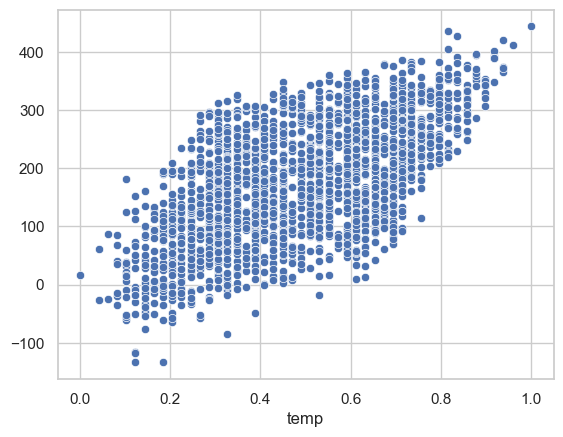

In [42]:
sns.scatterplot(x=X_test['temp'],y=y_pred_count)

<Axes: xlabel='humidity'>

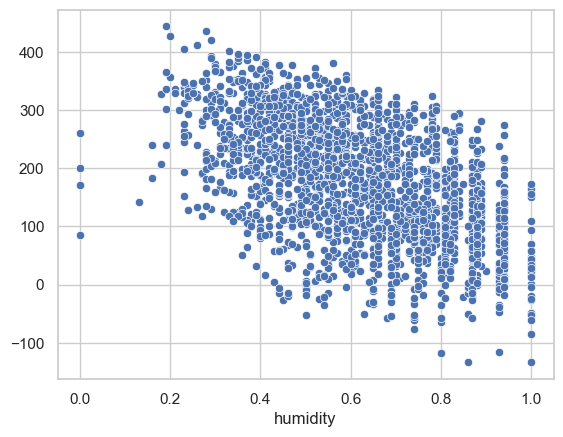

In [43]:
sns.scatterplot(x=X_test['humidity'],y=y_pred_count)